# Parallel Image Processing


### Environment setup

In [1]:
import skimage.restoration
import skimage.data
import skimage.io

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

plt.rcParams['font.family'] = 'monospace'

Reading [`cells.tif`](https://github.com/CameraIA/dipmicroct/blob/master/data/cells.tif)

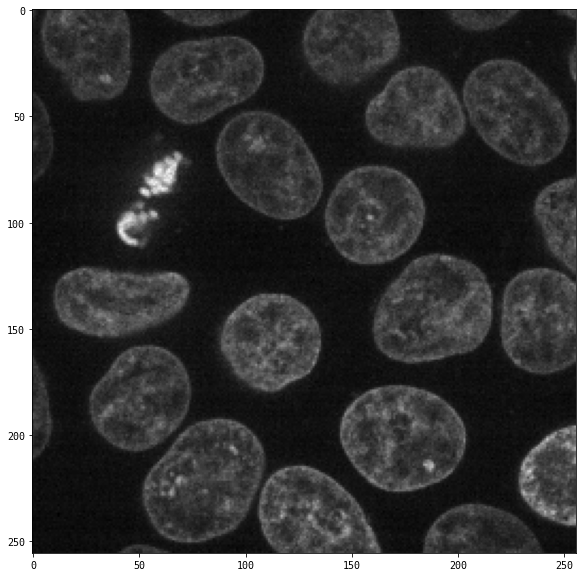

In [2]:
cells = skimage.io.imread('cells.tif')

plt.figure(figsize=(15, 10))
plt.imshow(cells[32], cmap='gray')

## Using joblib to parallelize code

Joblib is a set of tools to provide lightweight pipelining in Python. In particular:

1. transparent disk-caching of functions and lazy re-evaluation (known as _memoize pattern_)
2. easy simple parallel computing

Joblib is optimized to be fast and robust on large data in particular and has specific optimizations for numpy arrays.

* [[joblib documentation]](https://joblib.readthedocs.io/en/latest/)

Here we implement a function to apply the bilateral filter, the "classic" way.

In [3]:
def bilateral_classic_loop(data):
    """A function to apply the bilateral filter on 3D data."""
    # Setup empty array the same shape as input data
    data_bilateral = np.empty_like(data)
    
    # Apply the bilateral filter to each image individually
    for iPlane, plane in enumerate(data):
        data_bilateral[iPlane] = skimage.restoration.denoise_bilateral(plane,
                                                              multichannel=False)
    return data_bilateral

%time _ = bilateral_classic_loop(cells)

CPU times: user 2.86 s, sys: 78.1 ms, total: 2.94 s
Wall time: 2.95 s


Now we implement this function using `joblib`. 

In [4]:
from joblib import Parallel, delayed

# when using n_jobs=-2, all CPUs but one are used.

def bilateral_joblib_loop(data):
    data_bilateral = Parallel(n_jobs=-2)(delayed(
        skimage.restoration.denoise_bilateral
    )(plane, multichannel=False) for plane in data)

    return data_bilateral

%time _ = bilateral_joblib_loop(cells)

CPU times: user 188 ms, sys: 391 ms, total: 578 ms
Wall time: 2.15 s


We can use also `joblib.Memory` to cache results from a function.

In [5]:
from joblib import Memory

memory = Memory(location='../cache', verbose=0)

@memory.cache
def bilateral_joblib_loop(data):
    data_bilateral = Parallel(n_jobs=2)(delayed(
        skimage.restoration.denoise_bilateral
    )(plane, multichannel=False) for plane in data)

    return data_bilateral


# 1st execution
%time _ = bilateral_joblib_loop(cells)

# 2nd execution, cached
%time _ = bilateral_joblib_loop(cells)

CPU times: user 62.5 ms, sys: 46.9 ms, total: 109 ms
Wall time: 109 ms
CPU times: user 46.9 ms, sys: 62.5 ms, total: 109 ms
Wall time: 112 ms


## Parallelize operations with Dask.array

Dask allows parallel computing in python, coordinating many NumPy arrays arranged into a grid. Useful when dealing with collections of data that do not fit the RAM in your PC.

Let's split `cells` into four chunks, and map `skimage.filters.gaussian` on each block.

In [6]:
import dask.array as da
import skimage.filters

depth, rows, cols = cells.shape

%time
cells_dask = da.from_array(cells, chunks=(depth // 2, rows // 2, cols // 2), name=False)
cells_dask_gauss = cells_dask.map_overlap(skimage.filters.gaussian, depth=15, sigma=3, boundary='none')

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.15 µs


Let's see the structure of `cells_dask`. `.visualize()` shows the task graph:

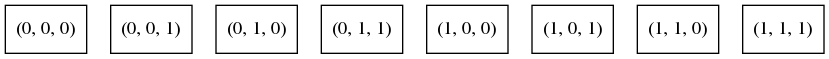

In [8]:
cells_dask.visualize()

Some commands to get `.visualize()` working:

`$ conda install graphviz python-graphviz`

`$ sudo apt install graphviz` (on Ubuntu)

Now, the structure of `cells_dask_gauss`.

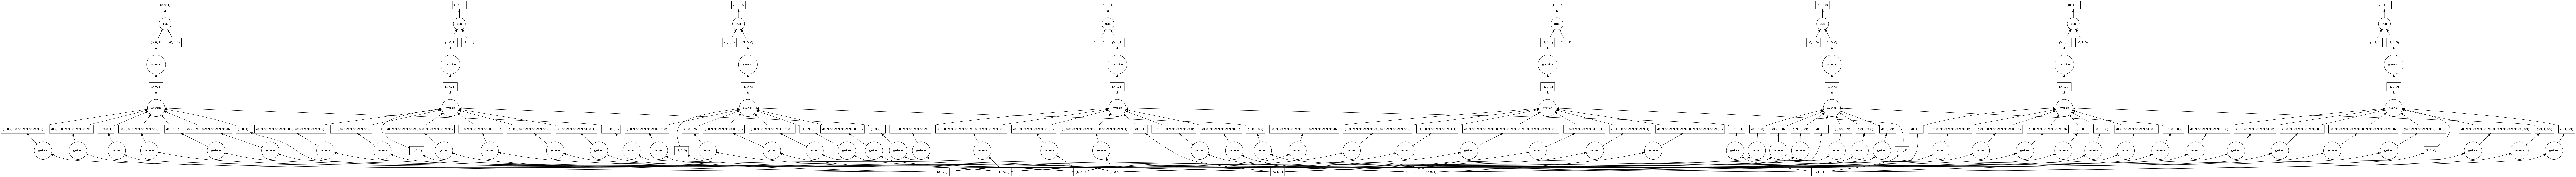

In [9]:
cells_dask_gauss.visualize()

Now, we use `.compute()` to actually calculate the operations.

In [10]:
%time _ = cells_dask_gauss.compute()

CPU times: user 625 ms, sys: 391 ms, total: 1.02 s
Wall time: 334 ms


## Going beyond

[1] Matt Rocklin's "Scikit-Image and Dask Experiment": https://nbviewer.jupyter.org/gist/mrocklin/ec745d6c2a12dddddb125ef460a4da76

[2] skimage's `util.apply_parallel`: https://scikit-image.org/docs/dev/api/skimage.util.html#skimage.util.apply_parallel

[3] Emmanuelle Gouillart's "Processing X-ray tomography images with Python": http://emmanuelle.github.io/segmentation-of-3-d-tomography-images-with-python-and-scikit-image.html

[4] Valentina Staneva's "Scalable Data Analysis": https://github.com/valentina-s/Dask_ImageXD_2018/blob/master/Scalable-Data-Analysis-with-Dask.ipynb